###1. Implement the following layers as python functions(both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

###2. Implement training and testing process
* included cross-validation

###3. Plot epoch-accuracy curves


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/AI_lab1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load MNIST dataset
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size  # 784
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",")

# data preprocessing

# map pixels information from range(0, 255) to range(0.01, 1)
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

print(train_imgs.shape)
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)


(60000, 784)


In [5]:
# Separate train_imgs, train_labels into training and validation

validation_split = 0.2
validation_imgs = train_imgs[int(train_imgs.shape[0] * (1 - validation_split)):]    # 20% of train_imgs (starting from index 48000)
validation_labels_one_hot = train_labels_one_hot[int(train_labels_one_hot.shape[0] * (1 - validation_split)):]  # 20% of train_labels_one_hot (starting from index 48000)
train_imgs = train_imgs[:int(train_imgs.shape[0] * (1 - validation_split))] # 80% of train_imgs (from index 0 to 47999)
train_labels_one_hot = train_labels_one_hot[:int(train_labels_one_hot.shape[0] * (1 - validation_split))]   # 80% of train_labels_one_hot (from index 0 to 47999)

print(train_imgs.shape)
print(train_labels_one_hot.shape)
print(validation_imgs.shape)
print(validation_labels_one_hot.shape)

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


In [6]:
#layer definition
def InnerProduct_ForProp(x,W,b):    # Forward Propagation
    y = np.dot(x,W) + b
    return y

def InnerProduct_BackProp(dEdy, x, W, b):   # Backward Propagation
    dEdx = np.dot(dEdy, W.T)
    dEdW = np.dot(x.T, dEdy)
    dEdb = np.sum(dEdy, axis=0)
    return dEdx, dEdW, dEdb

def Softmax_ForProp(x):  # Forward Propagation
    # Compute the unnormalized probabilities
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    # Normalize them for each example
    y = exp_x / exp_x.sum(axis=1, keepdims=True)
    return y

def Softmax_BackProp(y,t):  # Backward Propagation
    # y is the output of softmax function (class probabilities)
    # t is the one-hot representation of the label

    # Compute the gradient of softmax loss function with respect to the input x
    dEdx = y - t
    return dEdx

def Sigmoid_ForProp(x):  # Forward Propagation: 1/(1+exp(-x))
    y = 1 / (1 + np.exp(-x))
    return y

def Sigmoid_BackProp(dEdy,x):   # Backward Propagation: y * (1 - y)
    # Compute the gradient of sigmoid function with respect to the input x
    y = Sigmoid_ForProp(x)
    dydx = y * (1 - y)
    # Compute the gradient of sigmoid loss function with respect to the input x
    dEdx = dEdy * dydx
    return dEdx

def Rectified_ForProp(x):   # Forward Propagation: max(0,x)
    y = np.maximum(0, x)
    return y

def Rectified_BackProp(dEdy,x):   # Backward Propagation
    # dEdy is the gradient of loss function with respect to the input y
    # x is the inner product output before activation function

    # Compute the gradient of rectified linear unit function with respect to the input x
    dEdx = dEdy
    dEdx[x < 0] = 0
    return dEdx

def CrossEntropy(y,t):  # Cross Entropy Loss Function
    # y is the output of softmax function (class probabilities)
    # t is the one-hot representation of the label

    # Compute the cross entropy loss function
    loss = -np.sum(t * np.log(y + 1e-8)) / y.shape[0]
    return loss

# you can also create your own class which includes each layer

In [7]:
learning_rate = 1e-3
iteration = 100

In [8]:
hidden_layer_size = 64
output_layer_size = 10

# initialize weights and bias
W_hidden = np.random.randn(image_pixels, hidden_layer_size) * 0.01
b_hidden = np.zeros((1, hidden_layer_size))

W_output = np.random.randn(hidden_layer_size, output_layer_size) * 0.01
b_output = np.zeros((1, output_layer_size))

In [9]:
# training

# accuracy record
train_accuracy_record = []
val_accuracy_record = []

# loss record
train_loss_record = []
val_loss_record = []

for i in range(iteration):
    # Forward-propagation
    # Hidden layer
    inner_product_output1 = InnerProduct_ForProp(train_imgs, W_hidden, b_hidden)    # 48000 * 128
    sigmoid_output1 = Sigmoid_ForProp(inner_product_output1)    # 48000 * 128
    # Output layer
    inner_product_output2 = InnerProduct_ForProp(sigmoid_output1, W_output, b_output)   # 48000 * 10
    sigmoid_output2 = Sigmoid_ForProp(inner_product_output2)    # 48000 * 10
    # Softmax layer
    softmax_output = Softmax_ForProp(sigmoid_output2)   # 48000 * 10

    # Bakcward-propagation
    # Softmax layer
    dEdx_softmax = Softmax_BackProp(softmax_output, train_labels_one_hot)   # 48000 * 10
    # Output layer
    dEdx_sigmoid2 = Sigmoid_BackProp(dEdx_softmax, inner_product_output2)   # 48000 * 10
    dEdx_output, dEdW_output, dEdb_output = InnerProduct_BackProp(dEdx_sigmoid2, sigmoid_output1, W_output, b_output)
    # Hidden layer
    dEdx_sigmoid1 = Sigmoid_BackProp(dEdx_output, inner_product_output1)
    dEdx_hidden, dEdW_hidden, dEdb_hidden = InnerProduct_BackProp(dEdx_sigmoid1, train_imgs, W_hidden, b_hidden)

    # Parameters Updating (Gradient descent)
    # Output layer
    W_output -= learning_rate * dEdW_output
    b_output -= learning_rate * dEdb_output
    # Hidden layer
    W_hidden -= learning_rate * dEdW_hidden
    b_hidden -= learning_rate * dEdb_hidden
    
    # training accuracy and loss
    train_accuracy = np.mean(np.argmax(softmax_output, axis=1) == np.argmax(train_labels_one_hot, axis=1))
    train_loss = CrossEntropy(softmax_output, train_labels_one_hot)
    train_accuracy_record.append(train_accuracy)
    train_loss_record.append(train_loss)

    # Use validation data to evaluate model
    inner_product_output1 = InnerProduct_ForProp(validation_imgs, W_hidden, b_hidden)
    sigmoid_output1 = Sigmoid_ForProp(inner_product_output1)
    inner_product_output2 = InnerProduct_ForProp(sigmoid_output1, W_output, b_output)
    sigmoid_output2 = Sigmoid_ForProp(inner_product_output2)
    softmax_output = Softmax_ForProp(sigmoid_output2)

    # validation accuracy and loss
    val_accuracy = np.mean(np.argmax(softmax_output, axis=1) == np.argmax(validation_labels_one_hot, axis=1))
    val_loss = CrossEntropy(softmax_output, validation_labels_one_hot)
    val_accuracy_record.append(val_accuracy)
    val_loss_record.append(val_loss)
    
    print("Epoch: %d\nValidation Accuracy: %.2f" % (i+1, val_accuracy))


Epoch: 1
Validation Accuracy: 0.11
Epoch: 2
Validation Accuracy: 0.10
Epoch: 3
Validation Accuracy: 0.11
Epoch: 4
Validation Accuracy: 0.32
Epoch: 5
Validation Accuracy: 0.11
Epoch: 6
Validation Accuracy: 0.27
Epoch: 7
Validation Accuracy: 0.17
Epoch: 8
Validation Accuracy: 0.21
Epoch: 9
Validation Accuracy: 0.25
Epoch: 10
Validation Accuracy: 0.29
Epoch: 11
Validation Accuracy: 0.43
Epoch: 12
Validation Accuracy: 0.46
Epoch: 13
Validation Accuracy: 0.40
Epoch: 14
Validation Accuracy: 0.50
Epoch: 15
Validation Accuracy: 0.58
Epoch: 16
Validation Accuracy: 0.45
Epoch: 17
Validation Accuracy: 0.53
Epoch: 18
Validation Accuracy: 0.62
Epoch: 19
Validation Accuracy: 0.70
Epoch: 20
Validation Accuracy: 0.72
Epoch: 21
Validation Accuracy: 0.74
Epoch: 22
Validation Accuracy: 0.69
Epoch: 23
Validation Accuracy: 0.75
Epoch: 24
Validation Accuracy: 0.70
Epoch: 25
Validation Accuracy: 0.77
Epoch: 26
Validation Accuracy: 0.75
Epoch: 27
Validation Accuracy: 0.80
Epoch: 28
Validation Accuracy: 0.79
E

In [10]:
# Using test_images and test_labels to do the final test

# Use test data to evaluate model
inner_product_output1 = InnerProduct_ForProp(test_imgs, W_hidden, b_hidden)
sigmoid_output1 = Sigmoid_ForProp(inner_product_output1)
inner_product_output2 = InnerProduct_ForProp(sigmoid_output1, W_output, b_output)
sigmoid_output2 = Sigmoid_ForProp(inner_product_output2)
softmax_output = Softmax_ForProp(sigmoid_output2)

# test accuracy and loss
test_accuracy = np.mean(np.argmax(softmax_output, axis=1) == np.argmax(test_labels_one_hot, axis=1))
test_loss = CrossEntropy(softmax_output, test_labels_one_hot)

print("Test Accuracy: %.2f" % test_accuracy)

Test Accuracy: 0.92


In [11]:
# final train accuracy and loss
print("Final Train Accuracy: %f" % train_accuracy_record[-1])
print("Final Train Loss: %f" % train_loss_record[-1])

# final validation accuracy and loss
print("Final Validation Accuracy: %f" % val_accuracy_record[-1])
print("Final Validation Loss: %f" % val_loss_record[-1])

# final test accuracy and loss
print("Final Test Accuracy: %f" % test_accuracy)
print("Final Test Loss: %f" % test_loss)

Final Train Accuracy: 0.920604
Final Train Loss: 1.540975
Final Validation Accuracy: 0.925417
Final Validation Loss: 1.537818
Final Test Accuracy: 0.922700
Final Test Loss: 1.538778


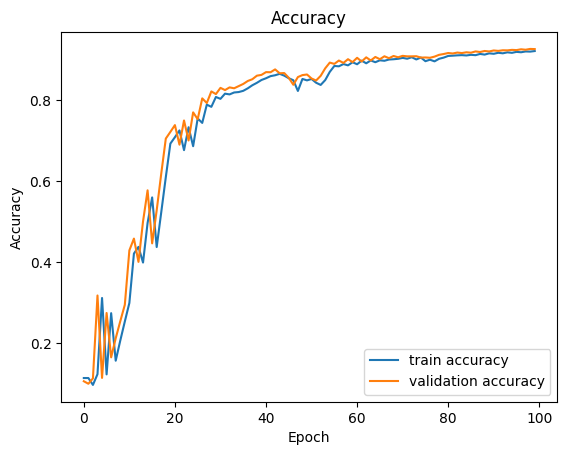

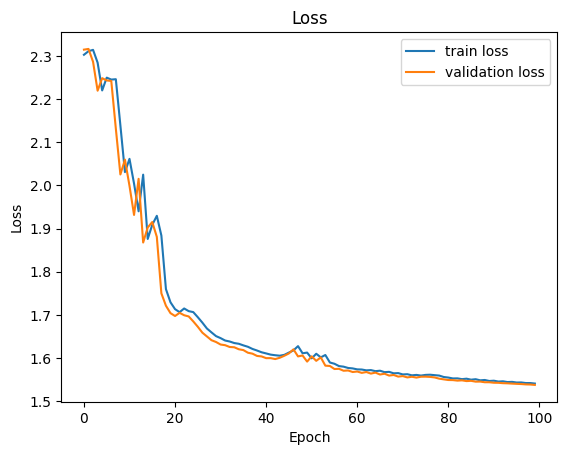

In [12]:
# plot accuracy and loss curves

# validation accuracy
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_accuracy_record, label='train accuracy')
plt.plot(val_accuracy_record, label='validation accuracy')
plt.legend()

# train loss and validation loss
plt.figure()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_record, label='train loss')
plt.plot(val_loss_record, label='validation loss')
plt.legend()